## Satellite image segmentation

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from mxnet.gluon.data import Dataset, DataLoader
from mxnet.gluon.loss import Loss
from mxnet import image

### Data preparation

In [31]:
from skimage.io import imsave, imread
from datetime import datetime
import collections

In [32]:
geopedia_layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905'}

In [33]:
class ImageWithMaskDataset(Dataset):
    """
    A dataset for loading images (with masks).
    Based on: mxnet.incubator.apache.org/tutorials/python/data_augmentation_with_masks.html
    
    Parameters
    ----------
    root : str
        Path to root directory.
    imgdir: str
        Path to folder containing the images, relative to root
    maskdir: str 
        Path to folder containing the masks/ground truth, relative to root
    transform : callable, default None
        A function that takes data and label and transforms them:
    ::
        transform = lambda data, label: (data.astype(np.float32)/255, label)
    """
    def __init__(self, imgdir, maskdir, transform=None):
        self._imgdir = os.path.expanduser(imgdir)
        self._maskdir = os.path.expanduser(maskdir)
        self._transform = transform
        self.imgdir = imgdir
        self._exts = ['.png']
        self._list_images(self._imgdir)

    def _list_images(self, root):
        images = collections.defaultdict(dict)
        for filename in sorted(os.listdir(root)):
            name, ext = os.path.splitext(filename)
            mask_flag = "geopedia" in name
            if ext.lower() not in self._exts:
                continue
            if not mask_flag:
                patch_id = filename.split('_')[1]
                year = datetime.strptime(filename.split('_')[3], "%Y%m%d-%H%M%S").year
                mask_fn = 'tulip_{}_geopedia_{}.png'.format(patch_id, geopedia_layers['tulip_field_{}'.format(year)])
                images[name]["base"] = filename
                images[name]["mask"] = mask_fn
        self._image_list = list(images.values())

    def __getitem__(self, idx):
        assert 'base' in self._image_list[idx], "Couldn't find base image for: " + image_list[idx]["mask"]
        base_filepath = os.path.join(self._imgdir, self._image_list[idx]["base"])
        base = mx.image.imread(base_filepath)
        assert 'mask' in self._image_list[idx], "Couldn't find mask image for: " + image_list[idx]["base"]
        mask_filepath = os.path.join(self._maskdir, self._image_list[idx]["mask"])
        mask = mx.image.imread(mask_filepath, flag=0)
        if self._transform is not None:
            return self._transform(base, mask)
        else:
            return base, mask

    def __len__(self):
        return len(self._image_list)

Image transformations for data augmentation. At the moment, data augmentation will happen offline before the training, so we will only use the transforms to reorder the channels, change data type, etc. Leaving the rest of them here in case this design choice changes in the future.

In [34]:
def positional_augmentation(joint):
    # Random crop
    crop_height = img_height
    crop_width  = img_width
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    return aug_joint

def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatenate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    # Convert mask to binary
    aug_mask = (aug_mask > 0.4).astype('float32')
    
    # Reshape the tensors so the order is now (channels, w, h)
    aug_base =  mx.nd.transpose(aug_base, (2,0,1))
    aug_mask =  mx.nd.transpose(aug_mask, (2,0,1))
    
    return aug_base, aug_mask

###  U-Net

In [35]:
def conv_block(channels, kernel_size):
    out = nn.HybridSequential()
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return out

In [36]:
def down_block(channels):
    out = nn.HybridSequential()
    out.add(
        conv_block(channels, 3),
        conv_block(channels, 3)
    )
    return out

In [37]:
class up_block(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(up_block, self).__init__(**kwargs)
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                                            padding=1, use_bias=False)
        self.conv1 = conv_block(channels, 1)
        self.conv3_0 = conv_block(channels, 3)
        if shrink:
            self.conv3_1 = conv_block(int(channels/2), 3)
        else:
            self.conv3_1 = conv_block(channels, 3)
    def hybrid_forward(self, F, x, s):
        x = self.upsampler(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.Crop(*[x,s], center_crop=True)
        x = s + x
        x = self.conv3_0(x)
        x = self.conv3_1(x)
        return x

In [38]:
class Unet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(Unet, self).__init__(**kwargs)
        with self.name_scope():
            self.d0 = down_block(64)
            
            self.d1 = nn.HybridSequential()
            self.d1.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(128))
            
            self.d2 = nn.HybridSequential()
            self.d2.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(256))
            
            self.d3 = nn.HybridSequential()
            self.d3.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(512))
            
            self.d4 = nn.HybridSequential()
            self.d4.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(1024))
            
            self.u3 = up_block(512, shrink=True)
            self.u2 = up_block(256, shrink=True)
            self.u1 = up_block(128, shrink=True)
            self.u0 = up_block(64, shrink=False)
            
            self.conv = nn.Conv2D(2,1)
            
    def hybrid_forward(self, F, x):
        x0 = self.d0(x)
        x1 = self.d1(x0)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        y3 = self.u3(x4,x3)
        y2 = self.u2(y3,x2)
        y1 = self.u1(y2,x1)
        y0 = self.u0(y1,x0)
        
        out = F.softmax(self.conv(y0), axis=1)
        
        return out

### Loss

The IoU metric tends to have a "squaring" effect on the errors relative to the Dice score (aka F score). So the F score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance.

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou

As we are not very confident on the quality of the training data/ground truth, lets go for the Dice coeff

In [39]:
class DiceCoeffLoss(Loss):
    """
    Soft dice coefficient loss.
    Based on https://github.com/Lasagne/Recipes/issues/99
    Input:
       pred: (batch size, c, w, h) network output, must sum to 1 over c channel (such as after softmax)
       label:(batch size, c, w, h) one hot encoding of ground truth
       eps; smoothing factor to avoid division by zero
    :param eps: 
    Output:
        Loss tensor with shape (batch size) 
    """

    def __init__(self, eps=1e-7, _weight = None, _batch_axis= 0, **kwards):
        Loss.__init__(self, weight=_weight, batch_axis=_batch_axis, **kwards)
        self.eps = eps

    def hybrid_forward(self, F, label, pred):  
        # One-hot encode the label
        label = nd.concatenate([label != 1, label], axis=1)
        
        axes = tuple(range(2, len(pred.shape)))
        intersect = nd.sum(pred * label, axis=axes)
        denom = nd.sum(pred + label, axis=axes)
        return - (2. *intersect / (denom + self.eps)).mean(axis=1)

### Evaluation metric

In [40]:
class DiceCoeffMetric(mx.metric.EvalMetric):
    """Stores a moving average of the dice coeff"""
    def __init__(self, axis=[2,3], smooth=1):
        super(DiceCoeffMetric, self).__init__('DiceCoeff')
        self.name = 'Dice coefficient'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        intersect = nd.sum((label * pred), axis=self.axis)
        dice = (2. * intersect + self.smooth)/(nd.sum(label, axis=self.axis) + nd.sum(pred, axis=self.axis) + self.smooth)
        self.sum_metric += nd.sum(dice, axis=0)
        self.num_inst += pred.shape[0]

        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)


In [41]:
class IouMetric(mx.metric.EvalMetric):
    """Stores a moving average of the intersection over union metric"""
    def __init__(self, axis=[2,3], smooth=1e-7):
        super(IouMetric, self).__init__('IoU')
        self.name = 'IoU'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        i = nd.sum((pred==1)*(label==1), axis=self.axis)
        u = nd.sum(pred, axis=self.axis) + nd.sum(label, axis=self.axis) - i
        iou = (i + self.smooth) / (u + self.smooth)
        self.sum_metric += nd.sum(iou, axis=0)
        self.num_inst += pred.shape[0]
        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)

In [42]:
def metric_str(names, vals):
    return '{}={}'.format(names, vals)

### Training

In [43]:
def evaluate(data_iterator, net):
    metric = IouMetric()
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # data = color_normalize(data/255, mean, std)
        output = net(data)
        pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
        # prediction = mx.nd.argmax(output, axis=1)
        metric.update(label, pred)
    return metric.get()[1]

In [44]:
def train_util(net, train_iter, val_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution
    '''
    os.makedirs(checkpoint_dir, exist_ok=True)
    res = {'train':[],'val':[]}
    for epoch in range(1 + init_epoch, epochs + init_epoch+1):
        metric = IouMetric()
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # Ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Normalize images?
            # data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(label, output)
                pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
                
            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update(label, pred)
            names, vals = metric.get()
            if i%25 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, vals)))
            if i!=0 and i%500 == 0:
                # Every 500 batches, save params and evaluate performance on the val set
                names, train_acc = metric.get()
                metric.reset()
                val_acc = evaluate(val_iter, net)
                net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, i))
                res['train'].append(train_acc)
                res['val'].append(val_acc)
                print("Epoch %s Batch %d| train IoU: %s | val IoU: %s " % (epoch, i, train_acc, val_acc))
                
        net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, 0))
        names, train_acc = metric.get()
        val_acc = evaluate(val_iter, net)
        res['train'].append(train_acc)
        res['val'].append(val_acc)
        print("Epoch %s | train IoU %s | val IoU %s " % (epoch, train_acc, val_acc))
        metric.reset()
        
    return res

### Run

In [45]:
ctx = mx.gpu(0)

In [46]:
batch_size = 8
img_width  = 256
img_height = 256

Training images can be found in the output folder of our Augmentor, train/, along with their corresponding masks. Validation images are in val/ but their masks are in masks/ . See prepare_data.ipynb for reference.

In [47]:
train_dir = '../data/tulips/bloom/train/'
val_dir   = '../data/tulips/bloom/val/'
mask_dir  = '../data/tulips/bloom/masks/'

Create train and validation DataLoaders from our Datasets. No transformations are applied because data augmentation takes place in a previous offline step.

In [48]:
train_ds = ImageWithMaskDataset(train_dir, train_dir, transform=joint_transform)
train_iter = gluon.data.DataLoader(train_ds, batch_size)

In [49]:
val_ds  = ImageWithMaskDataset(val_dir, mask_dir, transform=joint_transform)
val_iter= gluon.data.DataLoader(val_ds, batch_size)

The two cells below are only used to visually check if our ImageWithMaskDataset's are working.

In [50]:
def plot_mx_arrays(arrays):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    plt.subplots(figsize=(14, 8))
    for idx, array in enumerate(arrays):
        array = mx.nd.transpose(array, (1, 2, 0))
        if array.shape[2] != 3:
            array = nd.reshape(array, (array.shape[0],array.shape[0]))
        plt.subplot(1, 2, idx+1)
        plt.imshow(array.asnumpy())

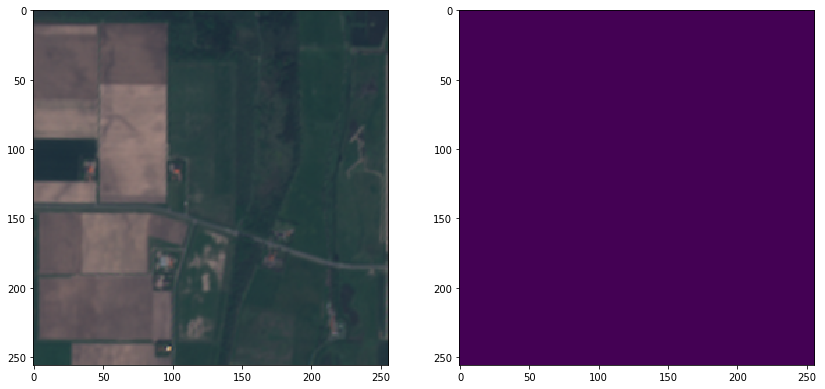

In [51]:
sample = val_ds.__getitem__(222)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

Instantiate a U-Net and train it

In [52]:
net = Unet()

In [53]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
net.hybridize()

In [54]:
loss = DiceCoeffLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', 
            {'learning_rate': 1e-4, 'beta1':0.9, 'beta2':0.99})

In [55]:
epochs = 50
checkpoint_dir = 'checkpoints/unet1'

In [ ]:
results = train_util(net, train_iter, val_iter, loss, trainer, ctx,
           epochs, batch_size, checkpoint_dir, init_epoch = 0)

In [29]:
np.save(checkpoint_dir + '/results.npy', results)

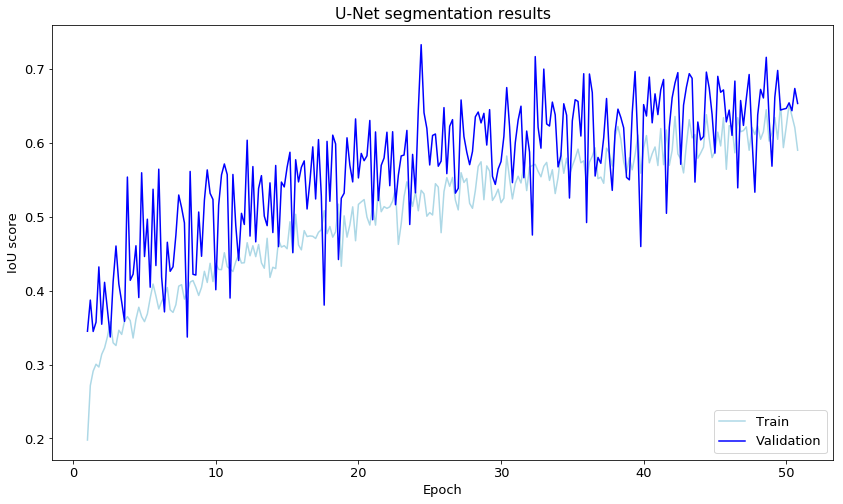

In [31]:
x = np.linspace(1, 51, 251)
plt.plot(x[:len(results['train'])], results['train'], label='Train', color='lightblue')
plt.plot(x[:len(results['val'])], results['val'], label='Validation', color='blue')
plt.title('U-Net segmentation results')
plt.xlabel('Epoch')
plt.ylabel('IoU score')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams.update({'font.size': 13})
plt.show()

Plot the results to visually compare the prediction and the actual ground truth 

In [248]:
def plot_image_results(img, label, net):
    # Prepare a single image batch
    batch = nd.reshape(img, (1, 3, img_width, img_height)).as_in_context(ctx)
    
    # Get prediction
    pred = net(batch)
    pred = nd.argmax(pred, axis=1)
    
    plt.subplots(figsize=(16, 8))
    # Plot image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(mx.nd.transpose(img, (1,2,0)).asnumpy())
    ax1.set_title("Image")

    # Plot prediction
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(pred[0].asnumpy(), cmap='gray')
    ax2.set_title("Predicted")

    # Plot groud truth
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(label[0].asnumpy(),  cmap='gray')
    ax3.set_title("True")
    plt.show()

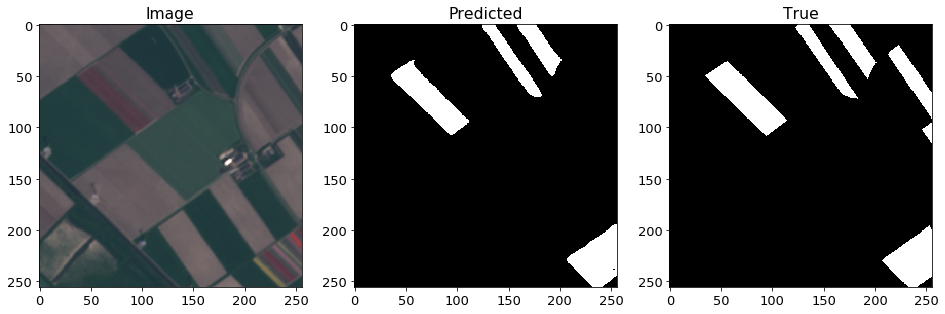

In [249]:
plot_image_results(sample_base, sample_mask, net)

In [67]:
# Find best scoring model 
results = np.load(checkpoint_dir + '/results.npy')[()]
best = results['val'].index(max(results['val'])) + 1
epoch, batch = divmod(best, 5)
epoch += 1
batch = ((batch + 1)%5)*500
best_params = os.path.join(checkpoint_dir, '{}-{}.params'.format(epoch, batch))
best_params

'checkpoints/unet1/24-2000.params'

In [69]:
net.load_params(best_params, ctx)

In [216]:
# Testing purposes
sample = val_ds.__getitem__(222)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

In [76]:
os.path.join(os.path.dirname(best_params), os.pardir, 'best_unet')

'checkpoints/unet1/../best_unet'

In [ ]:
plot_image_results(sample_base, sample_mask, net)